In [1]:
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')


In [2]:
# import kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download juhi1994/superstore




Dataset URL: https://www.kaggle.com/datasets/juhi1994/superstore
License(s): unknown
  0% 0.00/0.98M [00:00<?, ?B/s]
100% 0.98M/0.98M [00:00<00:00, 201MB/s]


In [3]:
from zipfile import ZipFile
file_name='superstore.zip'

with ZipFile(file_name,'r') as zip:
  zip.extractall('superstore')


In [4]:
df=pd.read_excel('/content/superstore/US Superstore data.xls')
df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


In [5]:
df.columns

Index(['Row ID', 'Order ID', 'Order Date', 'Ship Date', 'Ship Mode',
       'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State',
       'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category',
       'Product Name', 'Sales', 'Quantity', 'Discount', 'Profit'],
      dtype='object')

In [6]:
df.isna().sum()

,0
Row ID,0
Order ID,0
Order Date,0
Ship Date,0
Ship Mode,0
Customer ID,0
Customer Name,0
Segment,0
Country,0
City,0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Row ID         9994 non-null   int64         
 1   Order ID       9994 non-null   object        
 2   Order Date     9994 non-null   datetime64[ns]
 3   Ship Date      9994 non-null   datetime64[ns]
 4   Ship Mode      9994 non-null   object        
 5   Customer ID    9994 non-null   object        
 6   Customer Name  9994 non-null   object        
 7   Segment        9994 non-null   object        
 8   Country        9994 non-null   object        
 9   City           9994 non-null   object        
 10  State          9994 non-null   object        
 11  Postal Code    9994 non-null   int64         
 12  Region         9994 non-null   object        
 13  Product ID     9994 non-null   object        
 14  Category       9994 non-null   object        
 15  Sub-Category   9994 n

In [8]:
df.nunique()

,0
Row ID,9994
Order ID,5009
Order Date,1237
Ship Date,1334
Ship Mode,4
Customer ID,793
Customer Name,793
Segment,3
Country,1
City,531


In [ ]:
# country possess single category so drop it and rowid is of no need
df=df.drop(['Country','Row ID'],axis=1)

In [ ]:
df.shape

(9994, 19)

In [9]:
df.duplicated().sum()   #one row with duplicated value

np.int64(0)

In [10]:
df=df.drop_duplicates(keep="first")

In [11]:
df=df[['Order Date','Product Name', "Category","Sub-Category","Sales","Quantity","Profit"]]

In [12]:
df.head()

,Order Date,Product Name,Category,Sub-Category,Sales,Quantity,Profit
0,2016-11-08,Bush Somerset Collection Bookcase,Furniture,Bookcases,261.9600,2,41.9136
1,2016-11-08,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",Furniture,Chairs,731.9400,3,219.5820
2,2016-06-12,Self-Adhesive Address Labels for Typewriters b...,Office Supplies,Labels,14.6200,2,6.8714
3,2015-10-11,Bretford CR4500 Series Slim Rectangular Table,Furniture,Tables,957.5775,5,-383.0310
4,2015-10-11,Eldon Fold 'N Roll Cart System,Office Supplies,Storage,22.3680,2,2.5164


In [13]:
df.describe()

,Order Date,Sales,Quantity,Profit
count,9994,9994.000000,9994.000000,9994.000000
mean,2016-04-30 00:07:12.259355648,229.858001,3.789574,28.656896
min,2014-01-03 00:00:00,0.444000,1.000000,-6599.978000
25%,2015-05-23 00:00:00,17.280000,2.000000,1.728750
50%,2016-06-26 00:00:00,54.490000,3.000000,8.666500
75%,2017-05-14 00:00:00,209.940000,5.000000,29.364000
max,2017-12-30 00:00:00,22638.480000,14.000000,8399.976000
std,NaN,623.245101,2.225110,234.260108


In [ ]:
category_counts=df['Category'].value_counts(normalize=True)
category_counts

,proportion
Category,
Office Supplies,0.603022
Furniture,0.212149
Technology,0.184829


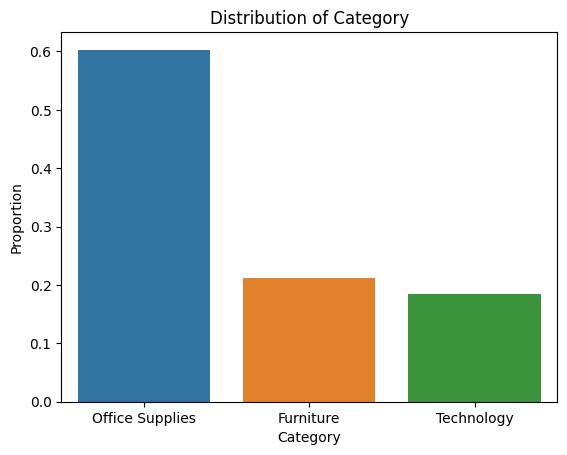

In [ ]:
num_categories=len(category_counts)
color_palette = sns.color_palette(n_colors=num_categories)
sns.barplot(x=category_counts.index,y=category_counts.values,palette=color_palette)
ax = sns.barplot(x=category_counts.index, y=category_counts.values, palette=color_palette)

# Set the title and labels for the plot
ax.set_title('Distribution of Category')
ax.set_xlabel('Category')
ax.set_ylabel('Proportion')

plt.show()

In [ ]:
sub_category_count=df['Sub-Category'].value_counts(normalize=True)
sub_category_count

,proportion
Sub-Category,
Binders,0.152407
Paper,0.137096
Furnishings,0.095767
Phones,0.088962
Storage,0.084659
Art,0.079656
Accessories,0.077554
Chairs,0.061643
Appliances,0.046633


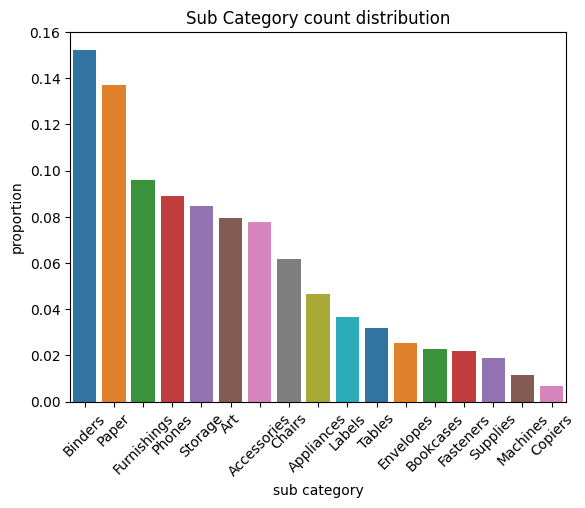

In [ ]:
color_palette=sns.color_palette(n_colors=len(sub_category_count))
ax=sns.barplot(x=sub_category_count.index,y=sub_category_count.values,palette=color_palette)
ax.set_title("Sub Category count distribution")
ax.set_xlabel("sub category")
ax.set_ylabel("proportion")
plt.xticks(rotation=45)
plt.show()

In [ ]:
# showing profit and sales per category
df_profit_sales=df.groupby("Category")[['Profit','Sales']].agg(['sum'])

<Axes: xlabel='Category'>

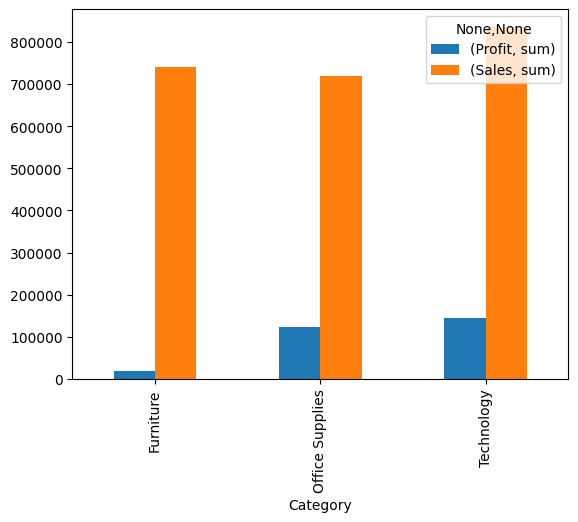

In [ ]:
df_profit_sales.plot.bar()

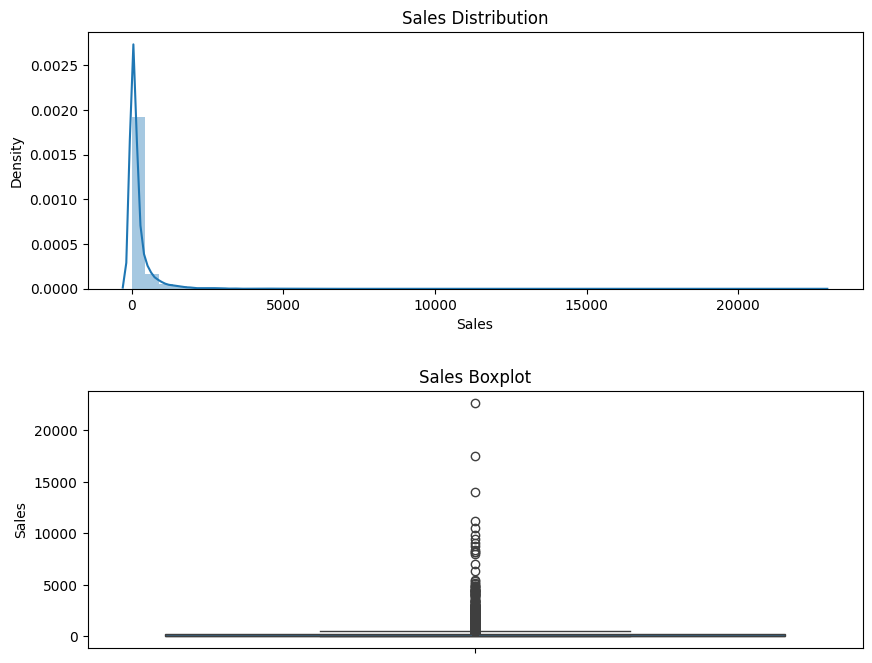

In [ ]:
plt.figure(figsize=(10,8))
plt.subplot(2,1,1)
sns.distplot(df['Sales'])
plt.title("Sales Distribution")
plt.subplot(2,1,2)
sns.boxplot(df["Sales"])
plt.title("Sales Boxplot")
plt.subplots_adjust(hspace=0.4)
plt.show()

In [ ]:
df['Order Date'].value_counts()

,count
Order Date,
2016-09-05,38
2017-09-02,36
2016-11-10,35
2017-12-01,34
2017-12-02,34
...,...
2014-11-06,1
2015-12-29,1
2016-06-03,1


In [ ]:
earliest_time=min(df['Order Date'])
latest_time=max(df['Order Date'])

In [ ]:
print("earliest time :", earliest_time)
print("latest time :",latest_time)

earliest time : 2014-01-03 00:00:00
latest time : 2017-12-30 00:00:00


In [ ]:
time_diff=df['Order Date'].diff()

In [ ]:
time_diff

,Order Date
0,NaT
1,0 days
2,-149 days
3,-245 days
4,0 days
...,...
9989,-1396 days
9990,1132 days
9991,0 days
9992,0 days


In [ ]:
by_category = df.groupby(['Category','Order Date']).sum("Sales").reset_index()

In [ ]:
by_category

,Category,Order Date,Sales,Quantity,Profit
0,Furniture,2014-01-06,2573.820,9,746.4078
1,Furniture,2014-01-07,76.728,3,-53.7096
2,Furniture,2014-01-10,51.940,1,21.2954
3,Furniture,2014-01-11,9.940,2,3.0814
4,Furniture,2014-01-13,879.939,9,91.2798
...,...,...,...,...,...
2856,Technology,2017-12-25,401.208,14,71.7174
2857,Technology,2017-12-27,164.388,2,-35.6174
2858,Technology,2017-12-28,14.850,3,4.0095
2859,Technology,2017-12-29,302.376,3,22.6782


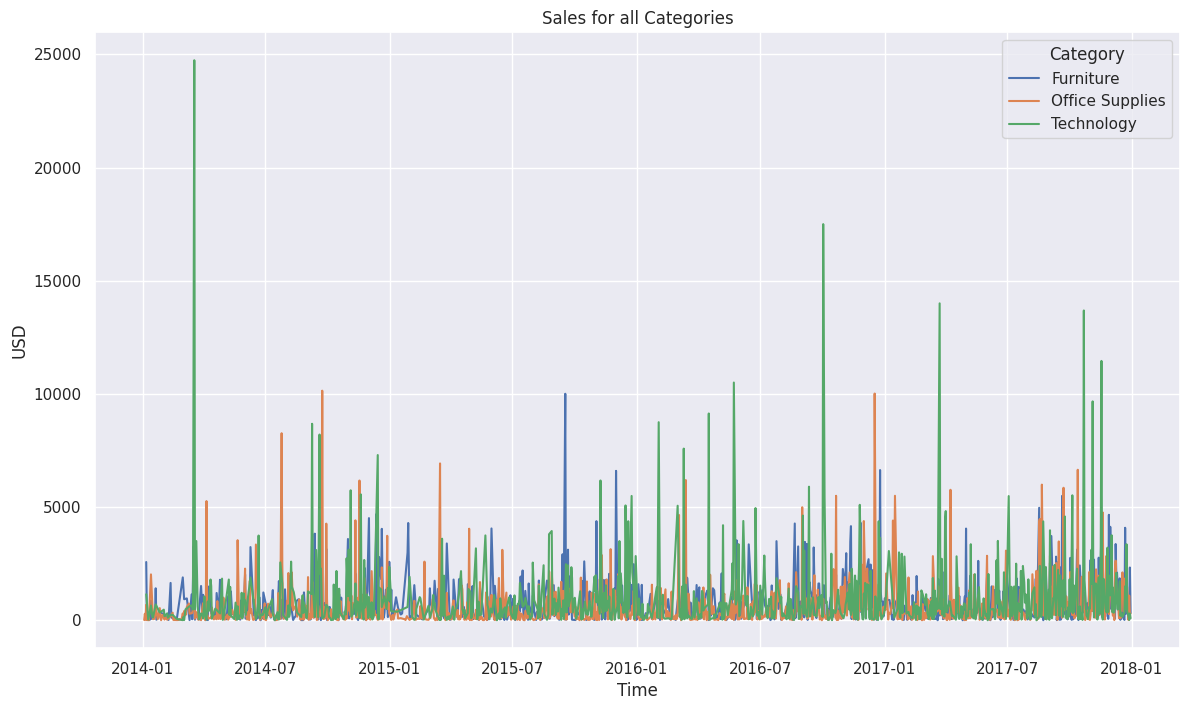

In [ ]:
sns.set(rc={'figure.figsize':(14,8)})    #after doing this no need to do plt.figure... every time
ax = sns.lineplot(data=by_category, x ='Order Date', y = 'Sales',
                  hue='Category',legend='full')      #hue=Category means each of category will be shown in different color
plt.ylabel('USD')
plt.xlabel('Time')
plt.title('Sales for all Categories')
plt.show()

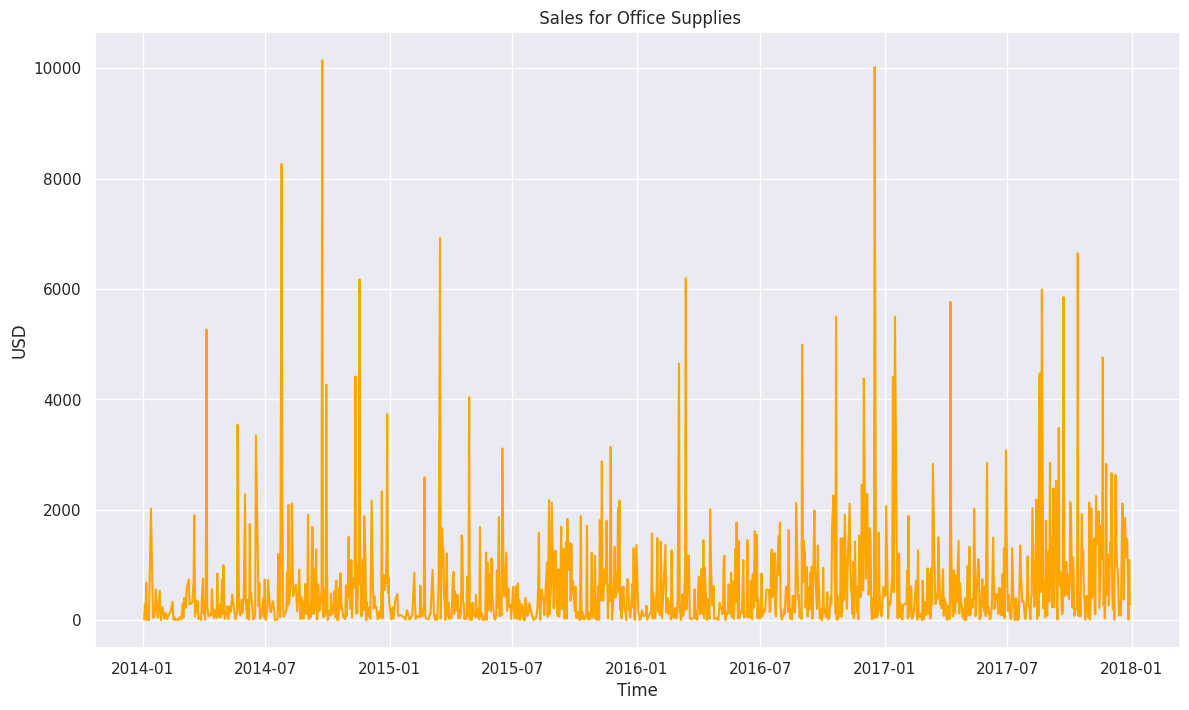

In [ ]:
ax = sns.lineplot(data=by_category[by_category["Category"]=="Office Supplies"], x ='Order Date', y = 'Sales',color="orange")
plt.ylabel('USD')
plt.xlabel('Time')
plt.title(' Sales for Office Supplies')
plt.show()

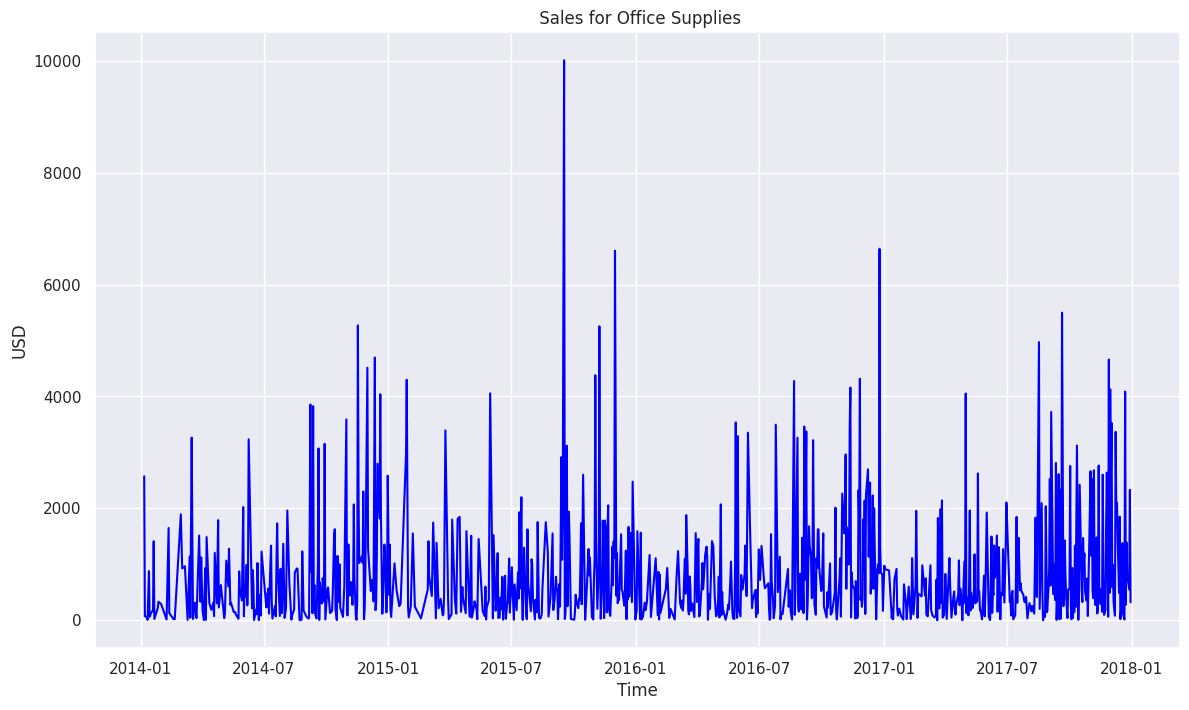

In [ ]:
ax = sns.lineplot(data=by_category[by_category["Category"]=="Furniture"], x ='Order Date', y = 'Sales',color="blue")
plt.ylabel('USD')
plt.xlabel('Time')
plt.title(' Sales for Office Supplies')
plt.show()

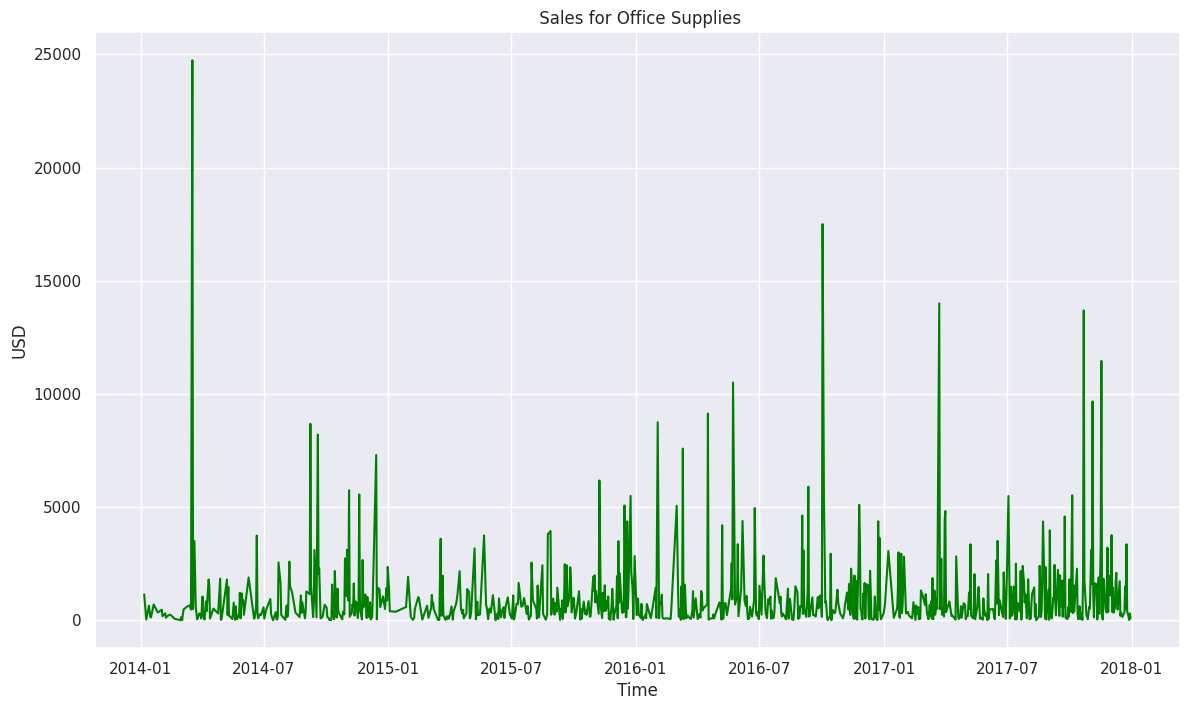

In [ ]:
ax = sns.lineplot(data=by_category[by_category["Category"]=="Technology"], x ='Order Date', y = 'Sales',color='green')
plt.ylabel('USD')
plt.xlabel('Time')
plt.title(' Sales for Office Supplies')
plt.show()

In [ ]:
by_product = df.groupby(['Product Name','Order Date']).sum("Sales").reset_index()    #sum the Sales from the unique combination of Product name and order date
by_product

,Product Name,Order Date,Sales,Quantity,Profit
0,"""While you Were Out"" Message Book, One Form pe...",2017-09-03,8.904,3,3.3390
1,"""While you Were Out"" Message Book, One Form pe...",2017-10-30,7.420,2,3.7100
2,"""While you Were Out"" Message Book, One Form pe...",2017-11-13,8.904,3,3.3390
3,"#10 Gummed Flap White Envelopes, 100/Box",2015-11-03,6.608,2,2.1476
4,"#10 Gummed Flap White Envelopes, 100/Box",2016-01-15,16.520,4,7.5992
...,...,...,...,...,...
9948,netTALK DUO VoIP Telephone Service,2014-12-05,167.968,4,62.9880
9949,netTALK DUO VoIP Telephone Service,2015-06-20,125.976,3,47.2410
9950,netTALK DUO VoIP Telephone Service,2015-09-25,104.980,2,52.4900
9951,netTALK DUO VoIP Telephone Service,2016-01-09,377.928,9,141.7230


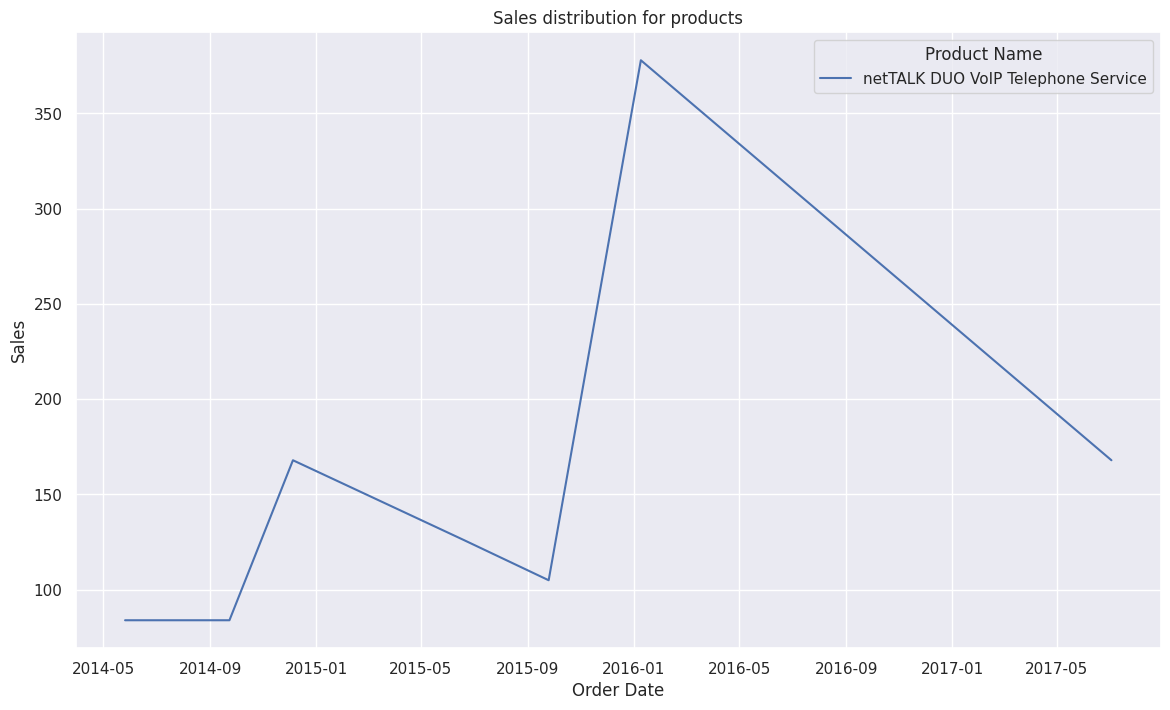

In [ ]:
ax=sns.lineplot(data=by_product[by_product['Product Name']=="netTALK DUO VoIP Telephone Service"],x="Order Date",y="Sales",hue="Product Name")
plt.title("Sales distribution for products")
plt.xlabel("Order Date")
plt.ylabel("Sales")
plt.show()

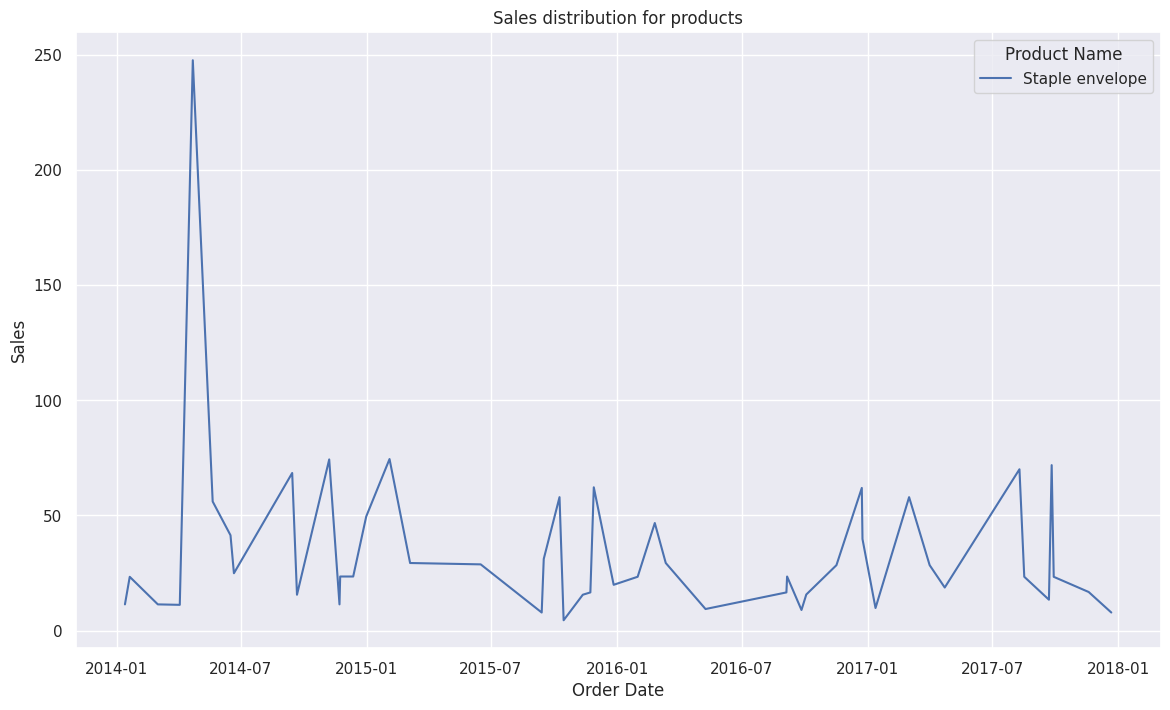

In [ ]:
ax=sns.lineplot(data=by_product[by_product['Product Name']=="Staple envelope"],x="Order Date",y="Sales",hue="Product Name")
plt.title("Sales distribution for products")
plt.xlabel("Order Date")
plt.ylabel("Sales")
plt.show()

In [ ]:
# Time series analysis

# Filter Office Supplies and retain only Order Date and Sales
df_new = by_category[by_category["Category"]=="Office Supplies"][['Order Date', 'Sales']]
# Convert Order Date to datetime dtype
df_new['Order Date'] = pd.to_datetime(df_new['Order Date'])
# Group by month
df_new = df_new.groupby(pd.Grouper(key='Order Date', freq='MS')).sum().reset_index()
# Display
df_new.head(5)

,Order Date,Sales
0,2014-01-01,4851.080
1,2014-02-01,1071.724
2,2014-03-01,8605.879
3,2014-04-01,11155.074
4,2014-05-01,7135.624


In [ ]:
time_diff1 = df_new['Order Date'].diff()
time_diff1.value_counts()

,count
Order Date,
31 days,27
30 days,16
28 days,3
29 days,1


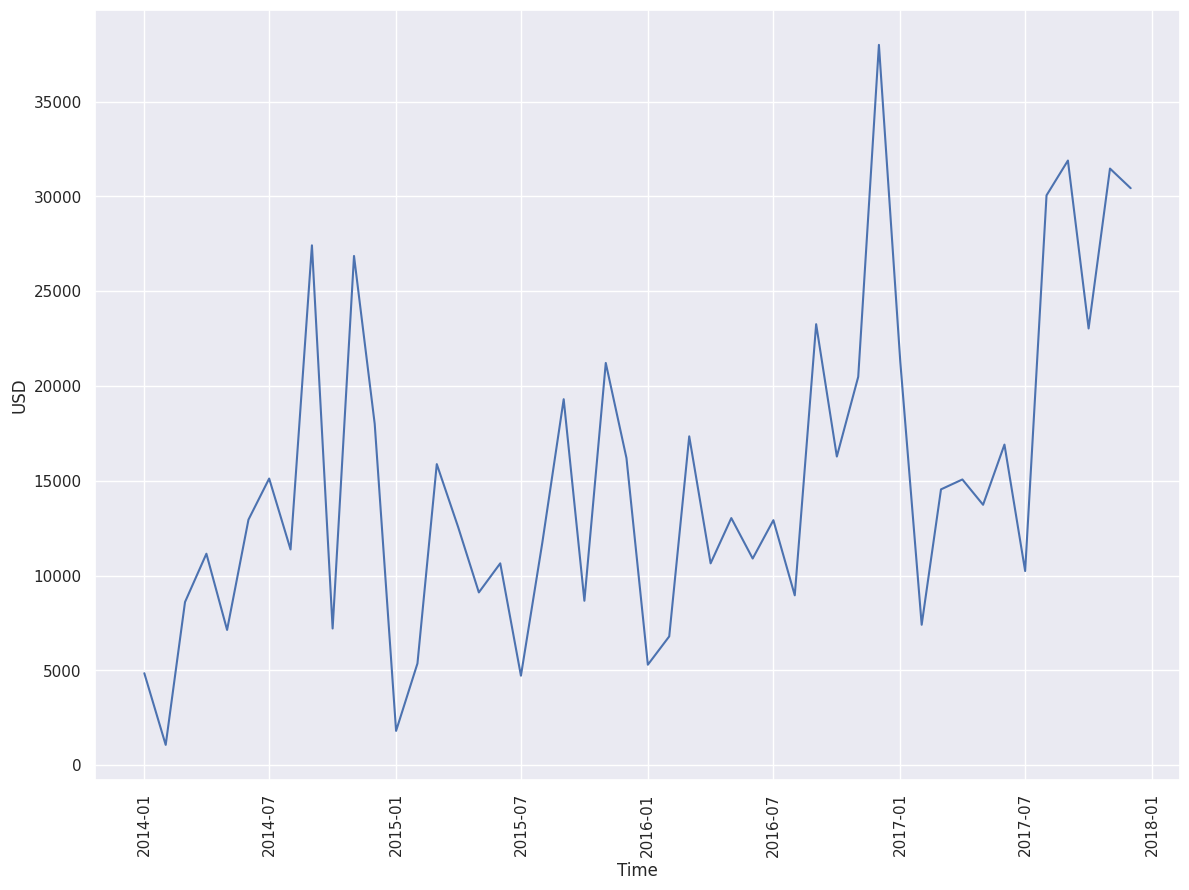

In [ ]:
sns.set(rc={'figure.figsize':(14,10)})
ax = sns.lineplot(data=df_new, x ='Order Date', y = 'Sales')
plt.ylabel('USD')
plt.xlabel('Time')
plt.xticks(rotation=90)
plt.show()

In [ ]:
def generate_ar_process(lags, coefs, length):

    #cast coefs to np array
    coefs = np.array(coefs)

    #initial values
    series = [np.random.normal() for _ in range(lags)]

    for _ in range(length):
        #get previous values of the series, reversed
        prev_vals = series[-lags:][::-1]

        #get new value of time series
        new_val = np.sum(np.array(prev_vals) * coefs) + np.random.normal()

        series.append(new_val)

    return np.array(series)

In [ ]:
# stationarity test
from statsmodels.tsa.stattools import adfuller
def perform_adf_test(series):
    result = adfuller(series)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])

In [ ]:
perform_adf_test(df_new['Sales'])

ADF Statistic: -1.905481
p-value: 0.329487


In [ ]:
# time series data is not stationery
# using differencing method to convert to stationery
df_new['diff_Sales'] = df_new['Sales'].diff()
# Drop missing values
df_new = df_new.dropna()

In [ ]:
df_new.head()

,Order Date,Sales,diff_Sales
1,2014-02-01,1071.724,-3779.356
2,2014-03-01,8605.879,7534.155
3,2014-04-01,11155.074,2549.195
4,2014-05-01,7135.624,-4019.450
5,2014-06-01,12953.037,5817.413


In [ ]:
# Test stationarity again for new data
perform_adf_test(df_new['diff_Sales'])

ADF Statistic: -4.308890
p-value: 0.000429


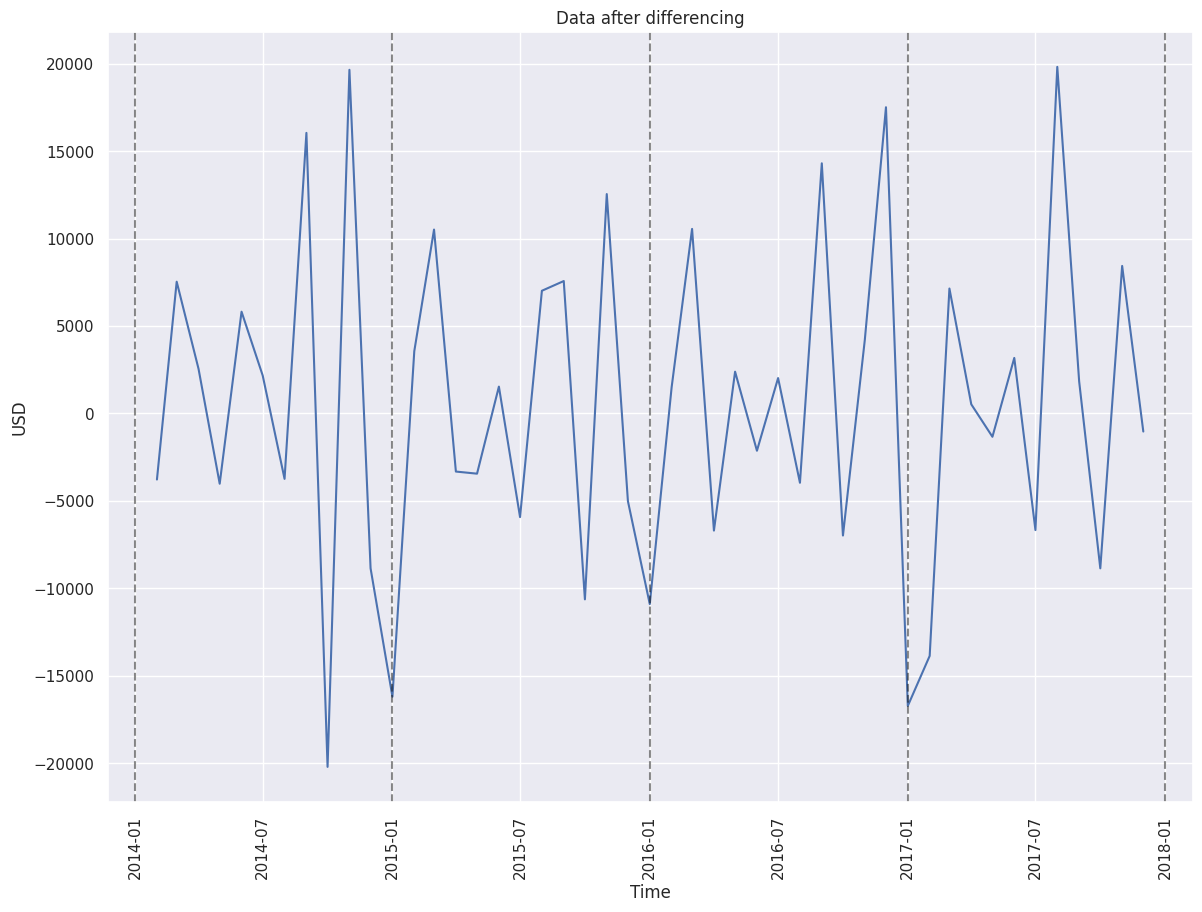

In [ ]:
# now the data is stationery:mean and variance is constant over time.
# Plot to see data again
from datetime import datetime
sns.lineplot(data=df_new, x ='Order Date', y = 'diff_Sales')
plt.ylabel('USD')
plt.xlabel('Time')
plt.xticks(rotation=90)
plt.title("Data after differencing")
for year in range(2014,2019):
    plt.axvline(datetime(year,1,1), color='k', linestyle='--', alpha=0.5)
plt.show()

In [ ]:
from statsmodels.tsa.seasonal import STL
# Remove freq info
df_new.set_index('Order Date', inplace=True)

In [ ]:
result = STL(df_new['diff_Sales'],period=12).fit()   #performing seasonal trend decomposition using loess
# seasonal-repeating patterns
# trend-upward or downward trend line
# residue-random noise

In [ ]:
seasonal, trend, resid = result.seasonal, result.trend, result.resid

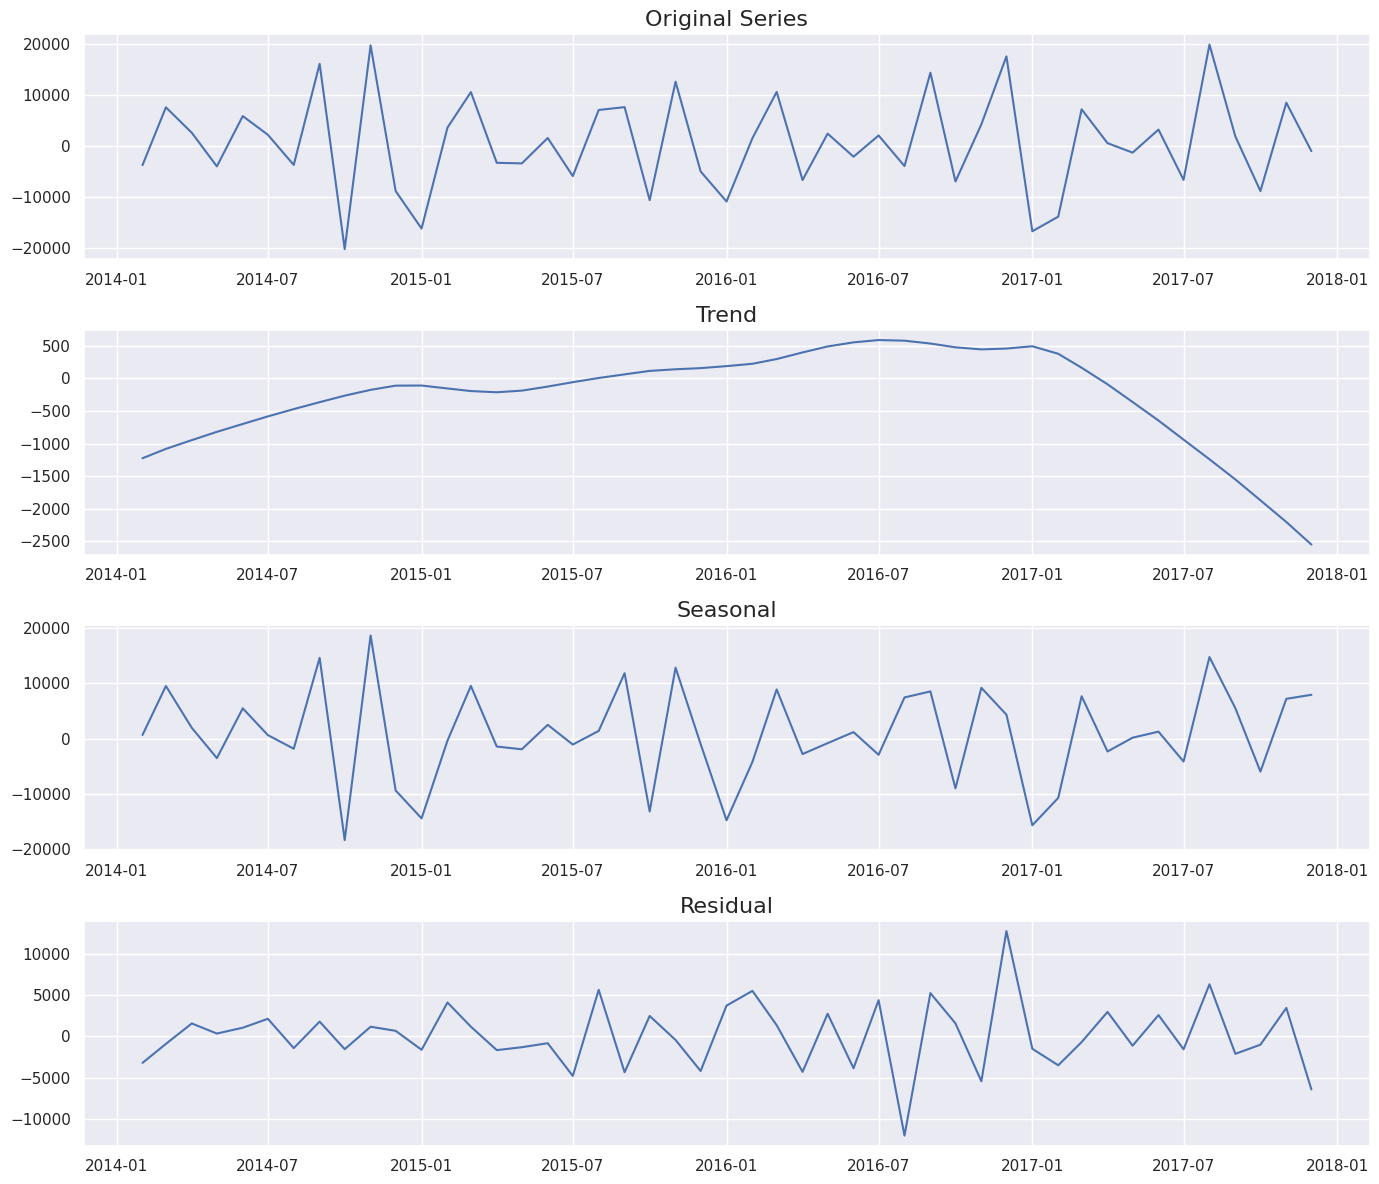

In [ ]:
plt.figure(figsize=(14,12))
plt.subplot(4,1,1)
plt.plot(df_new['diff_Sales'])
plt.title('Original Series', fontsize=16)
plt.subplot(4,1,2)
plt.plot(trend)
plt.title('Trend', fontsize=16)
plt.subplot(4,1,3)
plt.plot(seasonal)
plt.title('Seasonal', fontsize=16)
plt.subplot(4,1,4)
plt.plot(resid)
plt.title('Residual', fontsize=16)
plt.tight_layout()

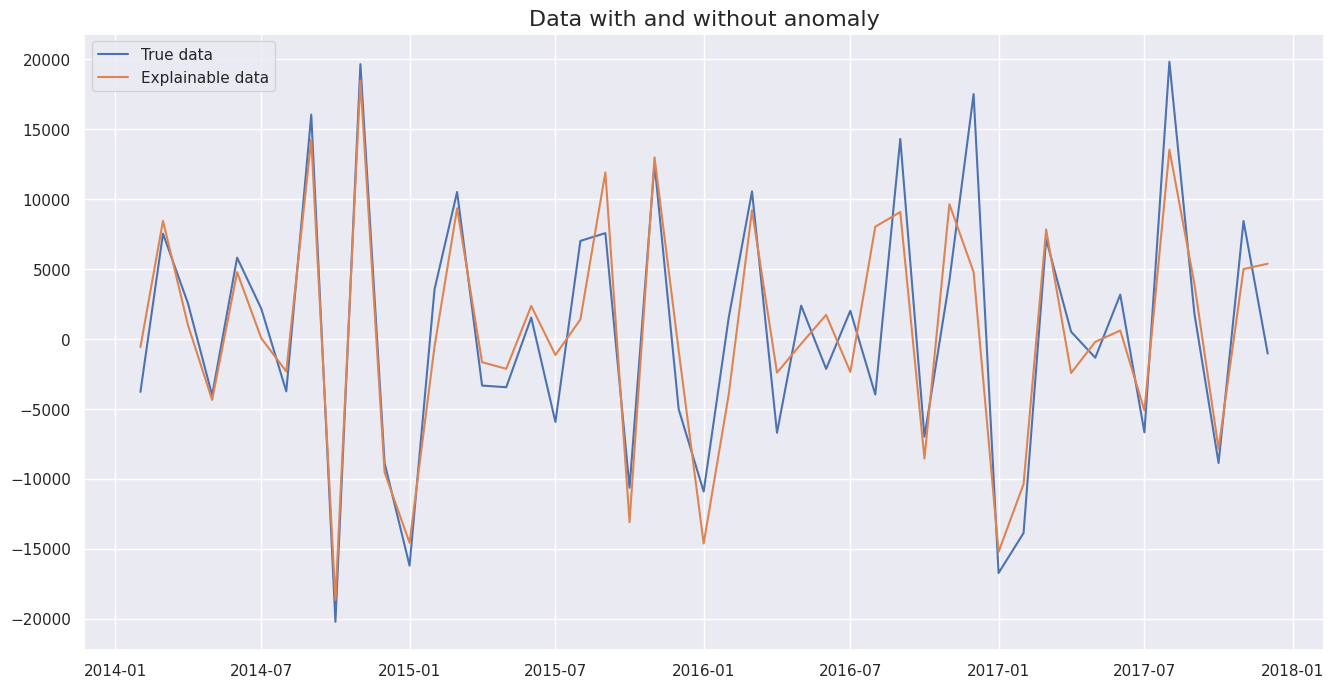

In [ ]:
# anamaoly detection
# Explainable data
estimated = trend + seasonal
#
plt.figure(figsize=(16,8))
plt.plot(df_new['diff_Sales'],label='True data')
plt.plot(estimated,label='Explainable data')
plt.legend()
plt.title('Data with and without anomaly', fontsize=16)
plt.show()

# visuallizing difference that is residue

To quantify if residuals are creating outliers in our data, we use the dispersion analysis to check the distribution of residuals around the mean. Here the threshold is 3 Standard Deviation.

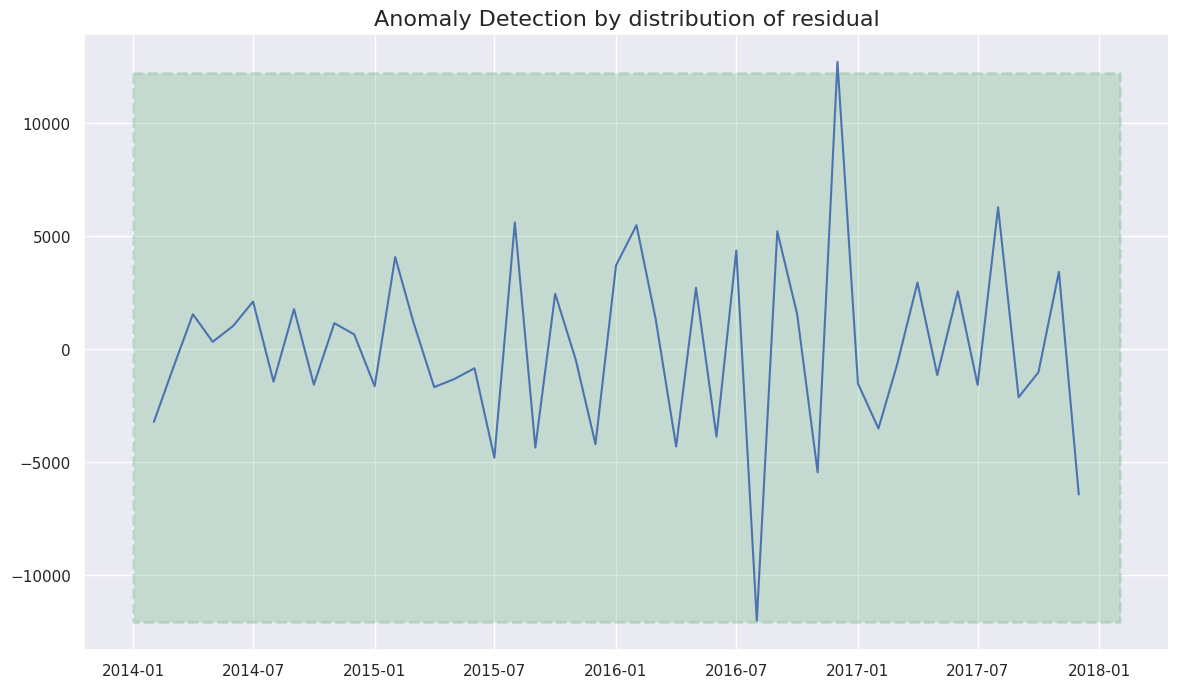

In [ ]:
# Calculate mean and sd
resid_mu = resid.mean()
resid_dev = resid.std()
# Assign upper and lower tails (3SD)
lower = resid_mu - 3*resid_dev
upper = resid_mu + 3*resid_dev
# Plot the data
plt.figure(figsize=(14,8))
plt.plot(resid)
plt.title('Anomaly Detection by distribution of residual', fontsize=16)
# Draw a rectangle to capture normal data
plt.fill_between([datetime(2014,1,1), datetime(2018,2,1)], lower, upper, color='g', alpha=0.25, linestyle='--', linewidth=2)

In [ ]:
df_new.head()

,Sales,diff_Sales
Order Date,,
2014-02-01,1071.724,-3779.356
2014-03-01,8605.879,7534.155
2014-04-01,11155.074,2549.195
2014-05-01,7135.624,-4019.450
2014-06-01,12953.037,5817.413


In [ ]:
# Calculate anomaly
# filter out the data frame to include only the row with residual value
anomalies = df_new[(resid < lower) | (resid > upper)]
# resid < lower) | (resid > upper)===returns a Boolean Series with the same index. When you pass that Boolean Series as a mask to df_new, it selects only the matching anomalous rows.

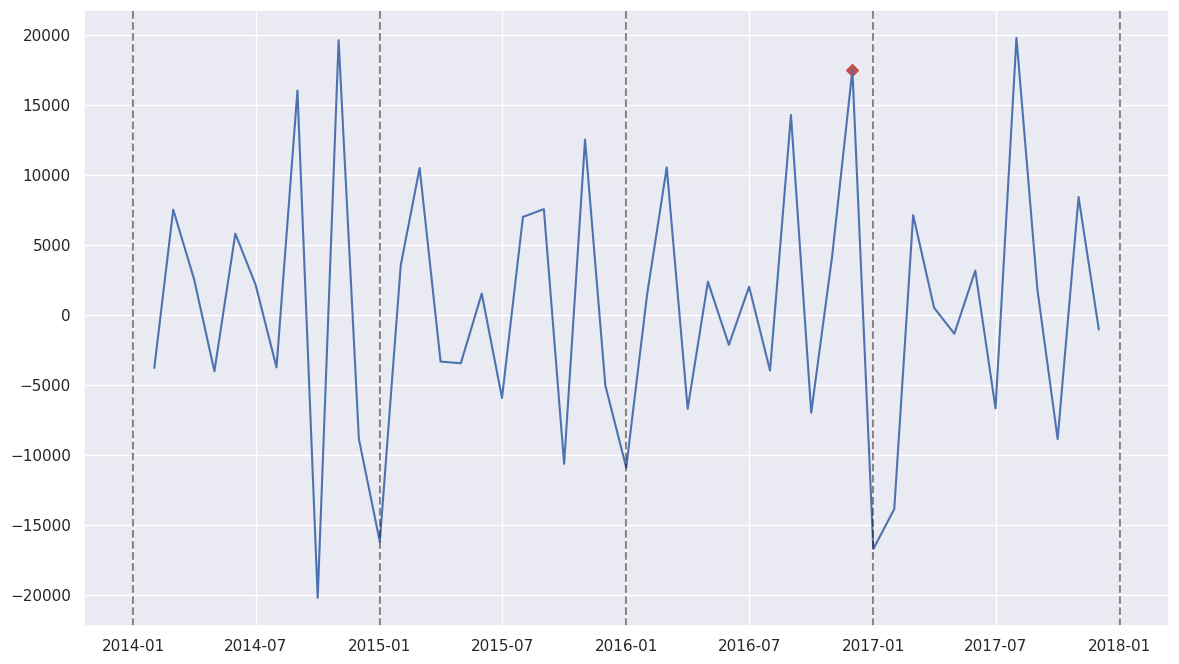

In [ ]:
# Plot anomaly
plt.figure(figsize=(14,8))
plt.plot(df_new['diff_Sales'])
for year in range(2014,2019):
    plt.axvline(datetime(year,1,1), color='k', linestyle='--', alpha=0.5)
plt.scatter(anomalies.index, anomalies.diff_Sales, color='r', marker='D')

In [ ]:
anomalies

,Sales,diff_Sales
Order Date,,
2016-12-01,37997.566,17510.288


In [ ]:
# checking white noise
# there is no pattern in residual so the data is white noise

In [ ]:
# ACF — Autocorrelation Function
# Measures the correlation between a time series and its lagged versions.

# Lag k means looking at the value k steps before the current time.

# ACF — Partial Autocorrelation Function
# Measures the correlation between a time series and its lag, after removing effects of intermediate lags.

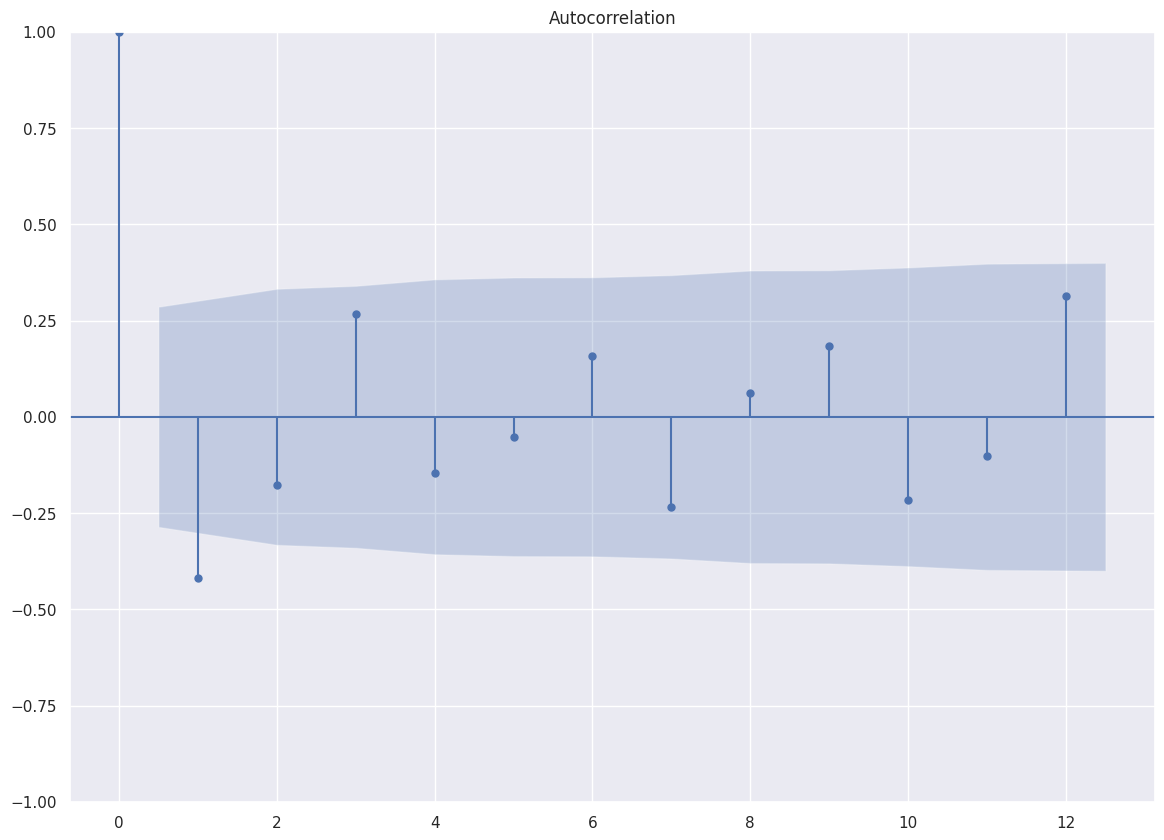

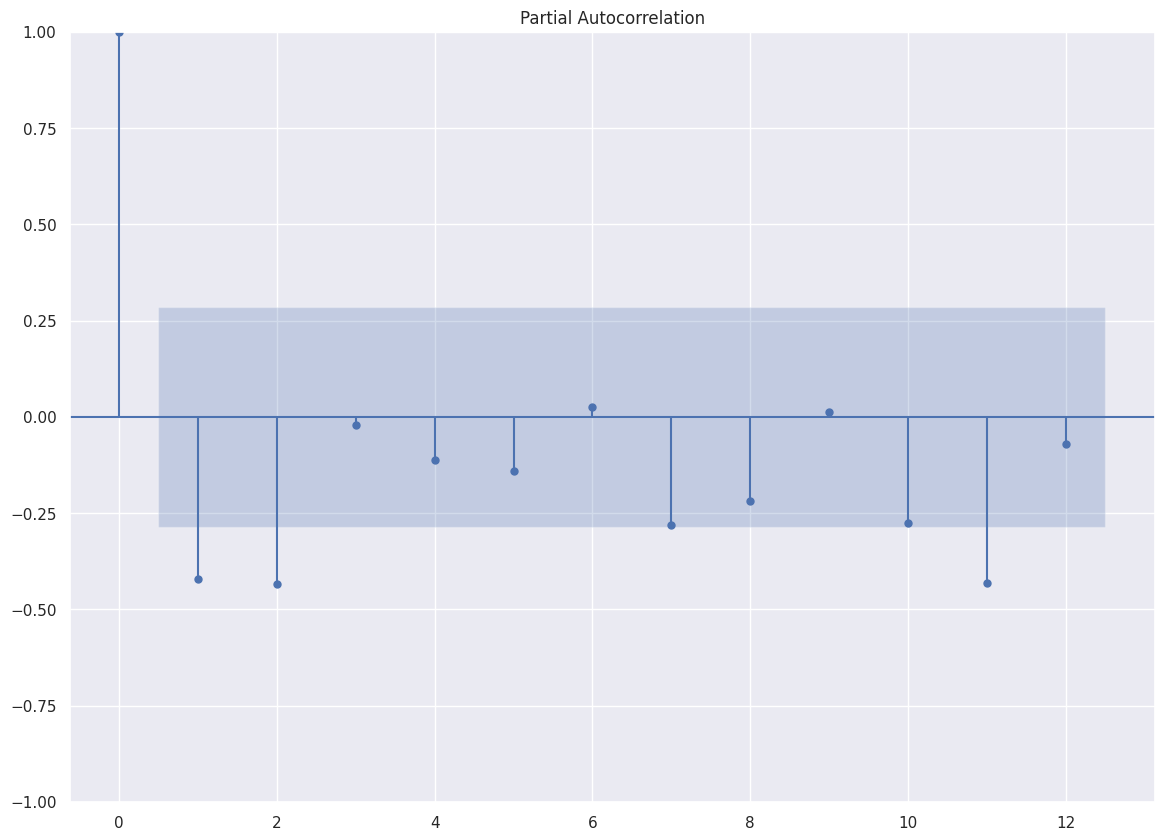

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# plot_acf====For each lag k, it plots how strongly the series at time t is correlated with the value at t−k.

plot_acf(df_new.diff_Sales, lags=12);

# plot_pacf=====Shows the direct correlation between the series and a lag, after removing effects of all shorter lags.

plot_pacf(df_new.diff_Sales, lags=12, method = "ols");

In [ ]:
from datetime import timedelta

test_end = datetime(2018,1,1)
train_end = datetime(2016,12,1) # Forecast sales for last 12 months
train_data = df_new[:train_end]
test_data = df_new[train_end + timedelta(days=1):test_end]


In [ ]:
from tqdm import tqdm_notebook
import statsmodels.api as sm
def optimize_ARIMA(order_list, exog):
    """
        Return dataframe with parameters and corresponding AIC

        order_list - list with (p, d, q) tuples
        exog - the exogenous variable
    """

    results = []

    for order in tqdm_notebook(order_list):
        try:
            model = sm.tsa.ARIMA(exog, order=order).fit()
        except:
            continue

        aic = model.aic
        results.append([order, model.aic])

    result_df = pd.DataFrame(results)
    result_df.columns = ['(p, d, q)', 'AIC']
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)

    return result_df

In [ ]:
import itertools
ps = range(0, 10, 1)
d = 1
qs = range(0, 10, 1)
# Create a list with all possible combination of parameters
parameters = itertools.product(ps,qs)
parameters_list = list(parameters)
order_list = []
for each in parameters_list:
    each = list(each)
    each.insert(1, d) # insert d in the second position
    each = tuple(each) # convert to tuble
    order_list.append(each)

result_df = optimize_ARIMA(order_list, exog=train_data['Sales'])
result_df

  0%|          | 0/100 [00:00<?, ?it/s]

,"(p, d, q)",AIC
0,"(5, 1, 8)",4.795992e+01
1,"(2, 1, 0)",7.108876e+02
2,"(0, 1, 1)",7.111792e+02
3,"(0, 1, 2)",7.124042e+02
4,"(1, 1, 1)",7.128363e+02
...,...,...
93,"(9, 1, 8)",1.980385e+13
94,"(7, 1, 8)",1.980385e+13
95,"(8, 1, 7)",1.980385e+13
96,"(6, 1, 7)",1.980385e+13


In [ ]:
best_model = sm.tsa.ARIMA(train_data['Sales'], order=(2,1,0)).fit()
print(best_model.summary())

                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                   35
Model:                 ARIMA(2, 1, 0)   Log Likelihood                -352.444
Date:                Fri, 25 Jul 2025   AIC                            710.888
Time:                        18:53:43   BIC                            715.467
Sample:                    02-01-2014   HQIC                           712.449
                         - 12-01-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7021      0.159     -4.428      0.000      -1.013      -0.391
ar.L2         -0.4257      0.157     -2.713      0.007      -0.733      -0.118
sigma2      5.851e+07   4.15e-10   1.41e+17      0.0

In [ ]:
df_new['ARIMA'] = best_model.predict(start=train_end, end=test_end)

<function matplotlib.pyplot.show(close=None, block=None)>

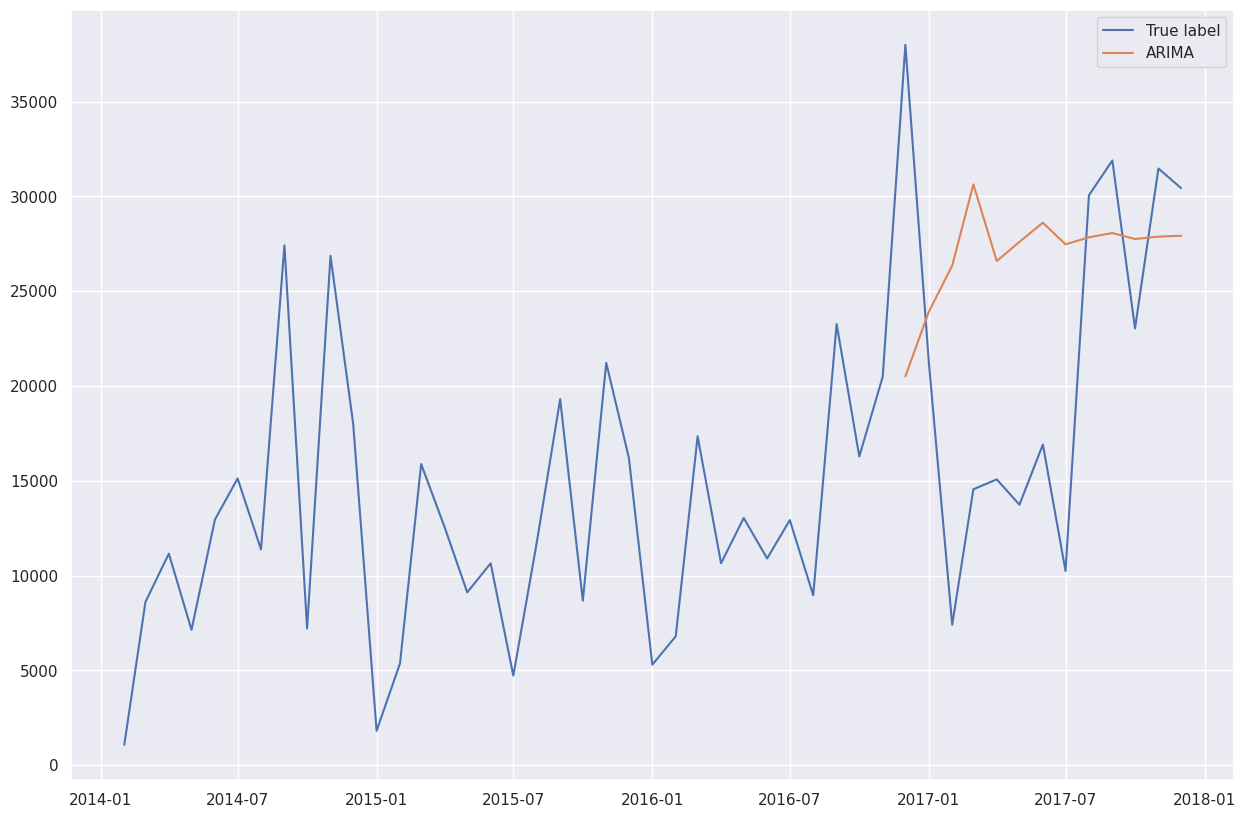

In [ ]:
# plot
plt.figure(figsize=[15,10])
plt.grid(True)
plt.plot(df_new['Sales'],label='True label')
plt.plot(df_new['ARIMA'],label='ARIMA')
plt.legend()
plt.show

In [ ]:
# Performance
print('Mean Absolute Percent Error for ARIMA:', round(np.mean(abs((df_new.loc[df_new.index>train_end,'Sales']-df_new.loc[df_new.index>train_end,'ARIMA'])/df_new.loc[df_new.index > train_end,'Sales']))*100,4),'%')

Mean Absolute Percent Error for ARIMA: 71.076 %


p,d,q: Non-seasonal AR order, differencing order, MA order

𝑃
,
𝐷
,
𝑄
P,D,Q: Seasonal AR order, seasonal differencing order, seasonal MA order

In [ ]:
def optimize_SARIMA(parameters_list, d, D, s, exog):
    """
        Return dataframe with parameters, corresponding AIC and SSE

        parameters_list - list with (p, q, P, Q) tuples
        d - integration order
        D - seasonal integration order
        s - length of season
        exog - the exogenous variable
    """

    results = []

    for param in tqdm_notebook(parameters_list):
        try:
            model = SARIMAX(exog, order=(param[0], d, param[1]), seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue

        aic = model.aic   # Akaike Information Criterion
        results.append([param, aic])   #it's a key metric used to evaluate and compare statistical models.

    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)x(P,Q)', 'AIC']
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)

    return result_df

In [ ]:
p = range(0, 4, 1)
d = 1
q = range(0, 4, 1)
P = range(0, 4, 1)
D = 1
Q = range(0, 4, 1)
s = 4
parameters = itertools.product(p, q, P, Q)   #gives all the possible combination of p,q,P,Q
parameters_list = list(parameters)   #conversion to list of tuples
print(len(parameters_list))

256


In [ ]:
result_df2 = optimize_SARIMA(parameters_list, d, D, s, train_data['Sales'])
result_df2
# lower AIC is better

  0%|          | 0/256 [00:00<?, ?it/s]

,"(p,q)x(P,Q)",AIC
0,"(1, 2, 0, 3)",622.904629
1,"(0, 3, 0, 2)",623.636842
2,"(1, 2, 2, 2)",623.668193
3,"(1, 2, 2, 1)",623.830351
4,"(1, 2, 2, 0)",625.324912
...,...,...
251,"(1, 1, 0, 0)",650.464299
252,"(0, 0, 2, 3)",651.609051
253,"(0, 0, 1, 0)",654.141368
254,"(1, 0, 0, 0)",654.407490


from matplotlib import pyplot as plt
result_df2['AIC'].plot(kind='hist', bins=20, title='AIC')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['AIC']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'AIC'}, axis=1)
              .sort_values('AIC', ascending=True))
  xs = counted['AIC']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = result_df2.sort_values('AIC', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('AIC')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
result_df2['AIC'].plot(kind='line', figsize=(8, 4), title='AIC')
plt.gca().spines[['top', 'right']].set_visible(False)

In [ ]:
best_SARIMA = SARIMAX(train_data['Sales'],order=(1, 1, 2), seasonal_order=(0, 1, 3, 4)).fit()
print(best_SARIMA.summary())

                                         SARIMAX Results                                         
Dep. Variable:                                     Sales   No. Observations:                   35
Model:             SARIMAX(1, 1, 2)x(0, 1, [1, 2, 3], 4)   Log Likelihood                -304.452
Date:                                   Fri, 25 Jul 2025   AIC                            622.905
Time:                                           18:57:55   BIC                            632.713
Sample:                                       02-01-2014   HQIC                           626.042
                                            - 12-01-2016                                         
Covariance Type:                                     opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9816      1.603      0.612      0.540    

In [ ]:
df_new['SARIMAX'] = best_SARIMA.predict(start=train_end, end=test_end)

<function matplotlib.pyplot.show(close=None, block=None)>

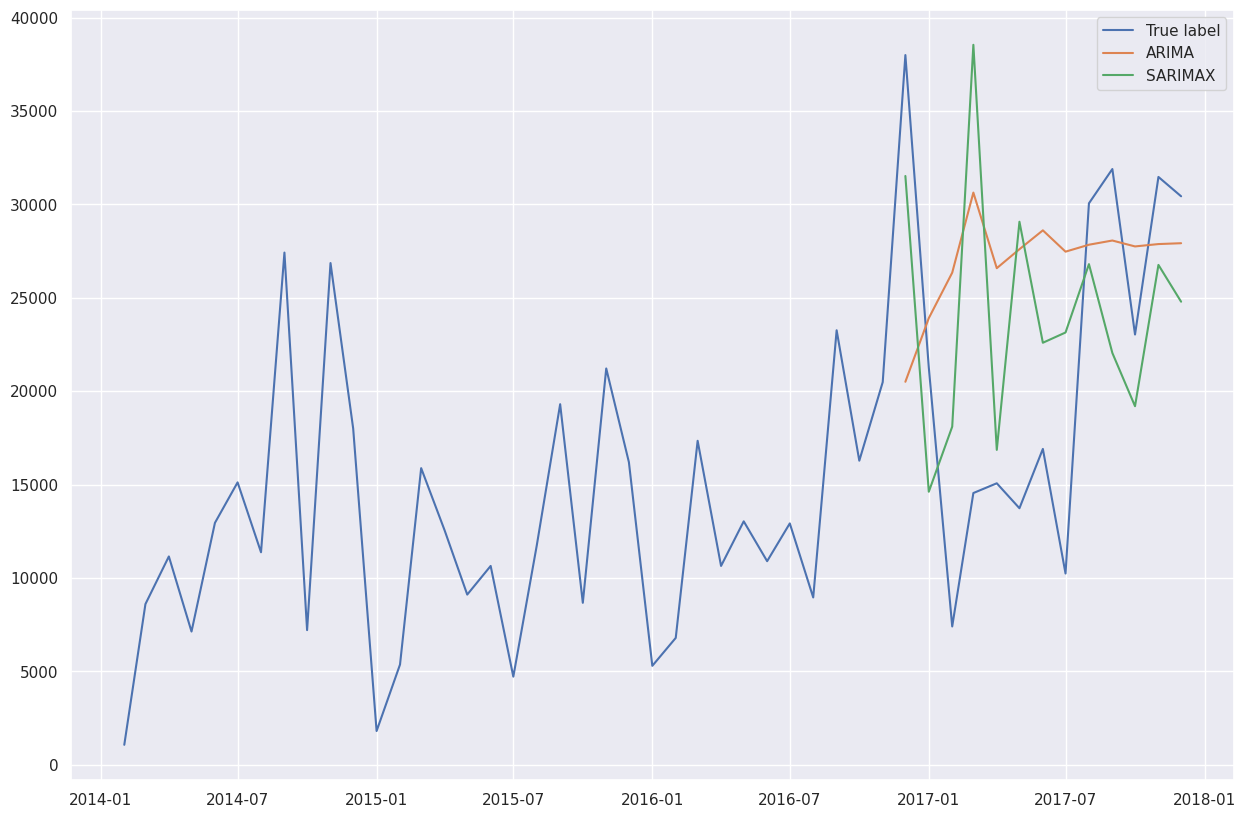

In [ ]:
# plot
plt.figure(figsize=[15,10])
plt.grid(True)
plt.plot(df_new['Sales'],label='True label')
plt.plot(df_new['ARIMA'],label='ARIMA')
plt.plot(df_new['SARIMAX'],label='SARIMAX')
plt.legend()
plt.show

In [ ]:
# Performance
print('Mean Absolute Percent Error for SARIMAX:', round(np.mean(abs((df_new.loc[df_new.index>train_end,'Sales']-df_new.loc[df_new.index>train_end,'SARIMAX'])/df_new.loc[df_new.index > train_end,'Sales']))*100,4),'%')

Mean Absolute Percent Error for SARIMAX: 59.6311 %


# SARIMAX SHOWED BETTER RESULT THEN ARIMAX


# now time series data forecasting with LSTM - the recurrent neural network

In [14]:
import torch.nn as nn
import torch
from torch.utils.data import Dataset, DataLoader

In [16]:
from sklearn.preprocessing import MinMaxScaler
df=df[["Order Date","Sales"]]
sales = df["Sales"].values.reshape(-1, 1)
scaler = MinMaxScaler()
sales_norm = scaler.fit_transform(sales)

In [25]:
df.head()

,Order Date,Sales
0,2016-11-08,261.9600
1,2016-11-08,731.9400
2,2016-06-12,14.6200
3,2015-10-11,957.5775
4,2015-10-11,22.3680


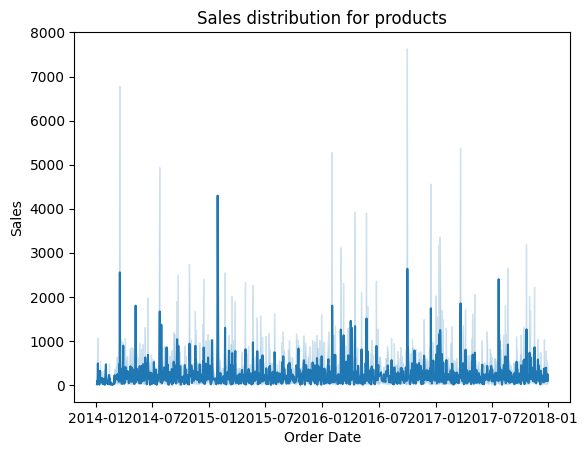

In [26]:
ax=sns.lineplot(data=df,x="Order Date",y="Sales")
plt.title("Sales distribution for products")
plt.xlabel("Order Date")
plt.ylabel("Sales")
plt.show()

In [17]:
def create_sequences(data, seq_len):
    xs, ys = [], []
    for i in range(len(data) - seq_len):
        xs.append(data[i:i+seq_len])   #from 30 rows of dataset in each sequences, 29 is the input and 30th is the target.each of 29 row is fed the input list and target is fed to the target list.
        ys.append(data[i+seq_len])
    return np.array(xs), np.array(ys)

In [18]:
seq_len = 30
X, y = create_sequences(sales_norm, seq_len)

In [19]:
class SalesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X).float()
        self.y = torch.from_numpy(y).float()
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
split = int(len(X) * 0.8)
train_ds = SalesDataset(X[:split], y[:split])
val_ds = SalesDataset(X[split:], y[split:])
train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=16)

# wrapping up our dataset to the pytorch dataset

In [20]:
class LSTMForecast(nn.Module):
    def __init__(self, n_features=1, hidden_size=50, num_layers=2):
        super().__init__()
        self.lstm = nn.LSTM(n_features, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)  # A fully connected (linear) layer that maps the LSTM output to a single prediction value.
    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])

In [21]:
model = LSTMForecast()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [22]:
for epoch in range(20):
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        pred = model(xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    model.eval()
    val_loss = np.mean([criterion(model(xb), yb).item() for xb, yb in val_loader])
    print(f"{epoch+1} → train {total_loss:.4f}, val {val_loss:.4f}")

1 → train 0.4188, val 0.0008
2 → train 0.3864, val 0.0008
3 → train 0.3830, val 0.0008
4 → train 0.3844, val 0.0008
5 → train 0.3829, val 0.0008
6 → train 0.3805, val 0.0008
7 → train 0.3816, val 0.0008
8 → train 0.3795, val 0.0008
9 → train 0.3793, val 0.0008
10 → train 0.3804, val 0.0008
11 → train 0.3793, val 0.0009
12 → train 0.3785, val 0.0008
13 → train 0.3789, val 0.0008
14 → train 0.3800, val 0.0008
15 → train 0.3779, val 0.0008
16 → train 0.3775, val 0.0008
17 → train 0.3779, val 0.0008
18 → train 0.3776, val 0.0008
19 → train 0.3781, val 0.0008
20 → train 0.3774, val 0.0008


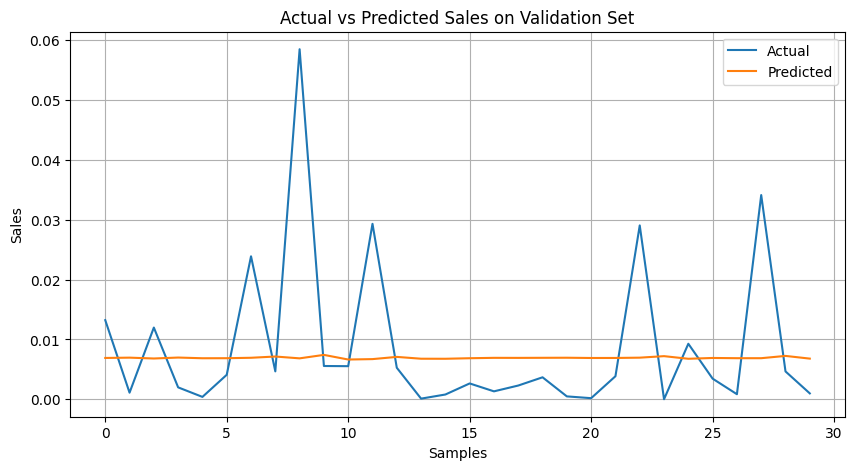

In [30]:
model.eval()
actuals = []
predictions = []

with torch.no_grad():
    for xb, yb in val_loader:
        pred = model(xb)
        actuals.extend(yb.cpu().numpy().flatten())
        predictions.extend(pred.cpu().numpy().flatten())

# Plot actual vs predicted
plt.figure(figsize=(10, 5))
plt.plot(actuals[:30], label='Actual')
plt.plot(predictions[:30], label='Predicted')
plt.title('Actual vs Predicted Sales on Validation Set')
plt.xlabel('Samples')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()



In [23]:
model.eval()
last_seq = sales_norm[-seq_len:]
preds = []

In [24]:
for _ in range(7):
    inp = torch.from_numpy(last_seq.reshape(1, seq_len, 1)).float()   #30 days of data is fed to predict the next outcome.then we can increse the step by one to predict the next day and so on .finally we get the desierd day of sales prediction.
    pred = model(inp).item()
    preds.append(pred)
    last_seq = np.roll(last_seq, -1)
    last_seq[-1] = pred
preds = scaler.inverse_transform(np.array(preds).reshape(-1,1))
print("Next 7-day forecast:", preds.flatten())

Next 7-day forecast: [158.67342803 157.34416725 157.2096557  157.2844593  157.34416725
 157.37031056 157.37874388]


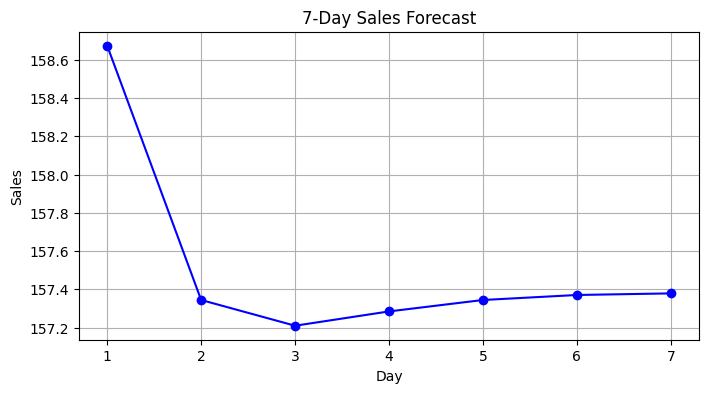

In [27]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming preds is a numpy array with shape (7, 1) after inverse transform
preds = preds.flatten()  # flatten to 1D array for plotting

# Create x-axis values (e.g., days 1 to 7)
days = np.arange(1, len(preds) + 1)

plt.figure(figsize=(8, 4))
plt.plot(days, preds, marker='o', linestyle='-', color='b')
plt.title("7-Day Sales Forecast")
plt.xlabel("Day")
plt.ylabel("Sales")
plt.xticks(days)
plt.grid(True)
plt.show()


<!--  -->